# Data Mining

In [1]:
from matplotlib import rcParams
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import re
from datetime import date
import datetime
from ast import literal_eval
#from pandas.plotting import register_matplotlib_converters
import glob
#register_matplotlib_converters()

today = date.today()
sns.set(style="white", palette="pastel",font_scale=1.5, rc={"lines.linewidth": 2.5,'figure.figsize':(11.7,8.27)})

In [2]:
pd.options.display.max_columns = None

In [3]:
import glob

path = r'C:\Users\neomo\Documents\GitHub\data_science_project_2\data' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

# loop for reading in all 55 .csv, glob makes a list of everythin matching the pattern
# eg all csv files in "path"

# Data Cleaning

In [4]:
df[np.invert(df.permissions.isnull())].permissions.head()

201     []
368     []
382     []
1343    []
1389    []
Name: permissions, dtype: object

In [5]:
df[np.invert(df.is_starred.isnull())].is_starred.head()

201     False
368     False
382     False
1343    False
1389    False
Name: is_starred, dtype: object

In [6]:
df[np.invert(df.is_backing.isnull())].is_backing.head()

201     False
368     False
382     False
1343    False
1389    False
Name: is_backing, dtype: object

In [7]:
df[np.invert(df.friends.isnull())].friends.head()

201     []
368     []
382     []
1343    []
1389    []
Name: friends, dtype: object

In [11]:
df.drop(["permissions","is_backing","is_starred","friends"], axis=1, inplace=True)

# columsn are empty or contain nonsenical data -> drop

In [8]:
col_date=['state_changed_at','created_at','launched_at','deadline']
for i in col_date:
    df[i]=df[i].apply(lambda x:
    datetime.datetime.fromtimestamp(int(x)).strftime("%Y-%m-%d %H:%M:%S"))
    
# reformat date time in readable format

In [9]:
df.state_changed_at = pd.to_datetime(df.state_changed_at)
df.created_at = pd.to_datetime(df.created_at)
df.launched_at = pd.to_datetime(df.launched_at)
df.deadline = pd.to_datetime(df.deadline)

# change dates to datetime object

In [12]:
df.dropna(inplace=True)

# drop remaining na values

In [13]:
df = df.sort_values(["id","state_changed_at"])

In [14]:
df.drop_duplicates(subset="id", inplace=True, keep="last")

# drop duplicates, keep last changed

In [15]:
df.drop(["id"], inplace=True, axis=1)

# Feature Engineering

## location

In [16]:
lat={"US":39.9,"GB":53.44,"FR":47.07,"AU":-25,"NZ":-41.93,'ES':40.06, 'IT':43.03, 'NO':61.52, 'NL':52.2, 'CA':60.26, 'SG':1.37,
       'MX':24.25, 'SE':62.89, 'IE':53.36, 'DE':51.08, 'BE':50.68, 'HK':22.39, 'AT':47.69, 'JP':36.59, 'DK':55.95, 'CH':46.89, 'LU':49.64}
long={"US": -102.1,"GB":-1.64,"FR":2.4,"AU":134.12,"NZ":172.88,'ES':-3.5, 'IT':12.6, 'NO':9.49, 'NL':5.65, 'CA':-110.66, 'SG':103.81,
       'MX':-102.45, 'SE':16.88, 'IE':-7.62, 'DE':10.34, 'BE':4.77, 'HK':114.16, 'AT':14.85, 'JP':139.16, 'DK':9.4, 'CH':8.21, 'LU':6.14}

In [17]:
df["lat"]=[lat[elm] for elm in df.country.values]
df["long"]=[long[elm] for elm in df.country.values]

# assign lat and long based on country

## average pledge

In [18]:
df["average_pledge"] = round((df.converted_pledged_amount / df.backers_count),2)

In [19]:
df["average_pledge"].fillna(0, inplace=True)
# calc average pledge, fill na with 0

## convert goal to USD

In [20]:
df['usd_goal'] = round((df.goal * df.static_usd_rate), 2)

# convert goal to usd for comparisons sake

## categories

In [21]:
cat = [eval(i)["slug"] for i in df.category]

In [22]:
cat2 = [elm.split("/") for elm in cat]

In [23]:
main_cat = [elm[0] for elm in cat2]
sub_cat = [elm[1] if len(elm) > 1 else elm[0] for elm in cat2]

In [24]:
df["cat"] = cat
df["main_cat"] = main_cat
df["sub_cat"] = sub_cat

# from category dictionary get cat combo, split into  main and sub, addd everything to dataframe

## slug length

In [28]:
key_word_count = [len(elm.split("-")) for elm in df.slug]

In [29]:
df["key_word_count"] = key_word_count

#extract lenght of name from slug entry

## start month

In [30]:
df['month'] = pd.DatetimeIndex(df['launched_at']).month
df["month"] = df.month.astype("object")

## launch year

In [31]:
df['year'] = pd.DatetimeIndex(df['launched_at']).year
df["year"] = df.year.astype("object")

## launch day

In [32]:
df['weekday_start'] = pd.DatetimeIndex(df['launched_at']).weekday+1
df["weekday_start"] = df.weekday_start.astype("object")

## end day

In [33]:
df['weekday_end'] = pd.DatetimeIndex(df['deadline']).weekday+1
df["weekday_end"] = df.weekday_end.astype("object")

## duration

In [34]:
df['duration'] = df.deadline - df.launched_at
df['duration'] = df['duration'].dt.floor('d')
df['duration'] = df['duration'].dt.days.astype('int16')

#calculate start and end day and month and year from dates

## blurb length

In [35]:
df['blurb_len'] = [elm.split(" ") for elm in df.blurb]
df['blurb_len'] = [len(i) for i in df['blurb_len']]

# calculate blurb length (didnt matter in the end)

# date exploration

## splitting dataframes

In [37]:
dfsuc = df[df.state == "successful"]

In [39]:
dffail = df[df.state == "failed"]

In [41]:
dflive = df[df.state == "live"]

In [43]:
df = pd.concat([dfsuc,dffail], axis=0, ignore_index=True)

# split dataframe into succ failed and live, only keep succ and failed as the 
# others are few in number and not applicable for our business case

## countries

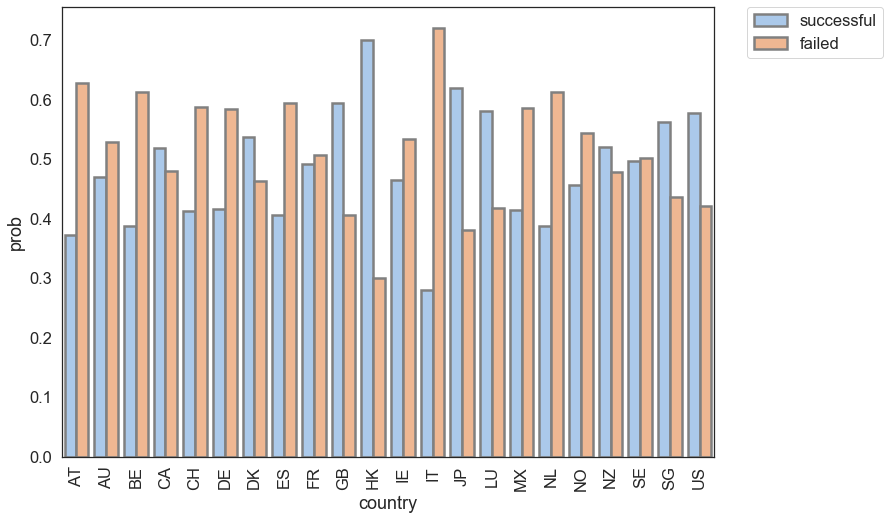

In [45]:

hue_order = ["successful","failed"]
sns.barplot(x="country", y="prob",
            data = df["state"].groupby(df["country"]).value_counts(normalize=True).rename("prob").reset_index(),
            hue="state",edgecolor="grey",linewidth=2.5,hue_order=hue_order)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fancybox=True);

# succ + failed = 100% for each country, (HK;GB,SG and US are good candidates)

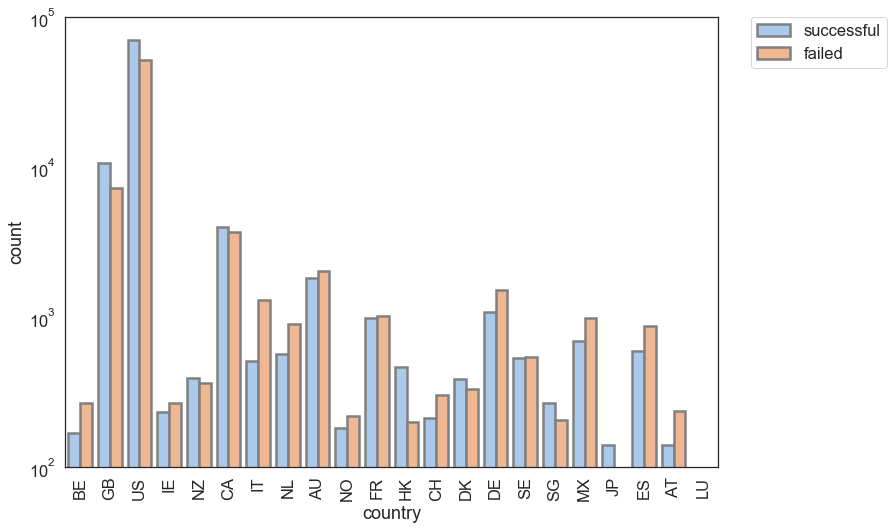

In [46]:
sns.countplot(df.country, hue=df.state,edgecolor="grey",linewidth=2.5)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fancybox=True)
plt.yscale("log")
plt.ylim(100,100000);

# absolute numbers for country

## categories

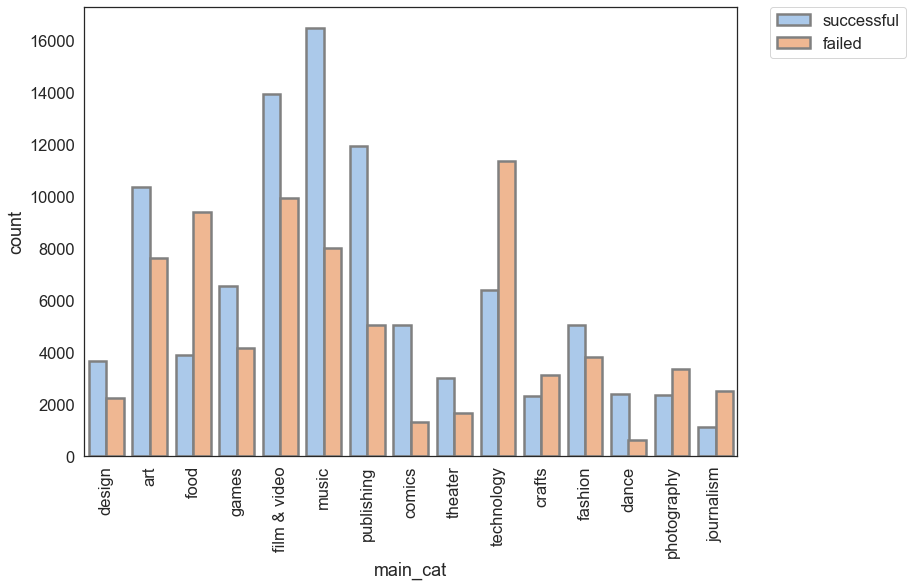

In [47]:
sns.countplot(df.main_cat, hue=df.state,edgecolor="grey",linewidth=2.5)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fancybox=True);

# absolute numbers succ and fail for each cat

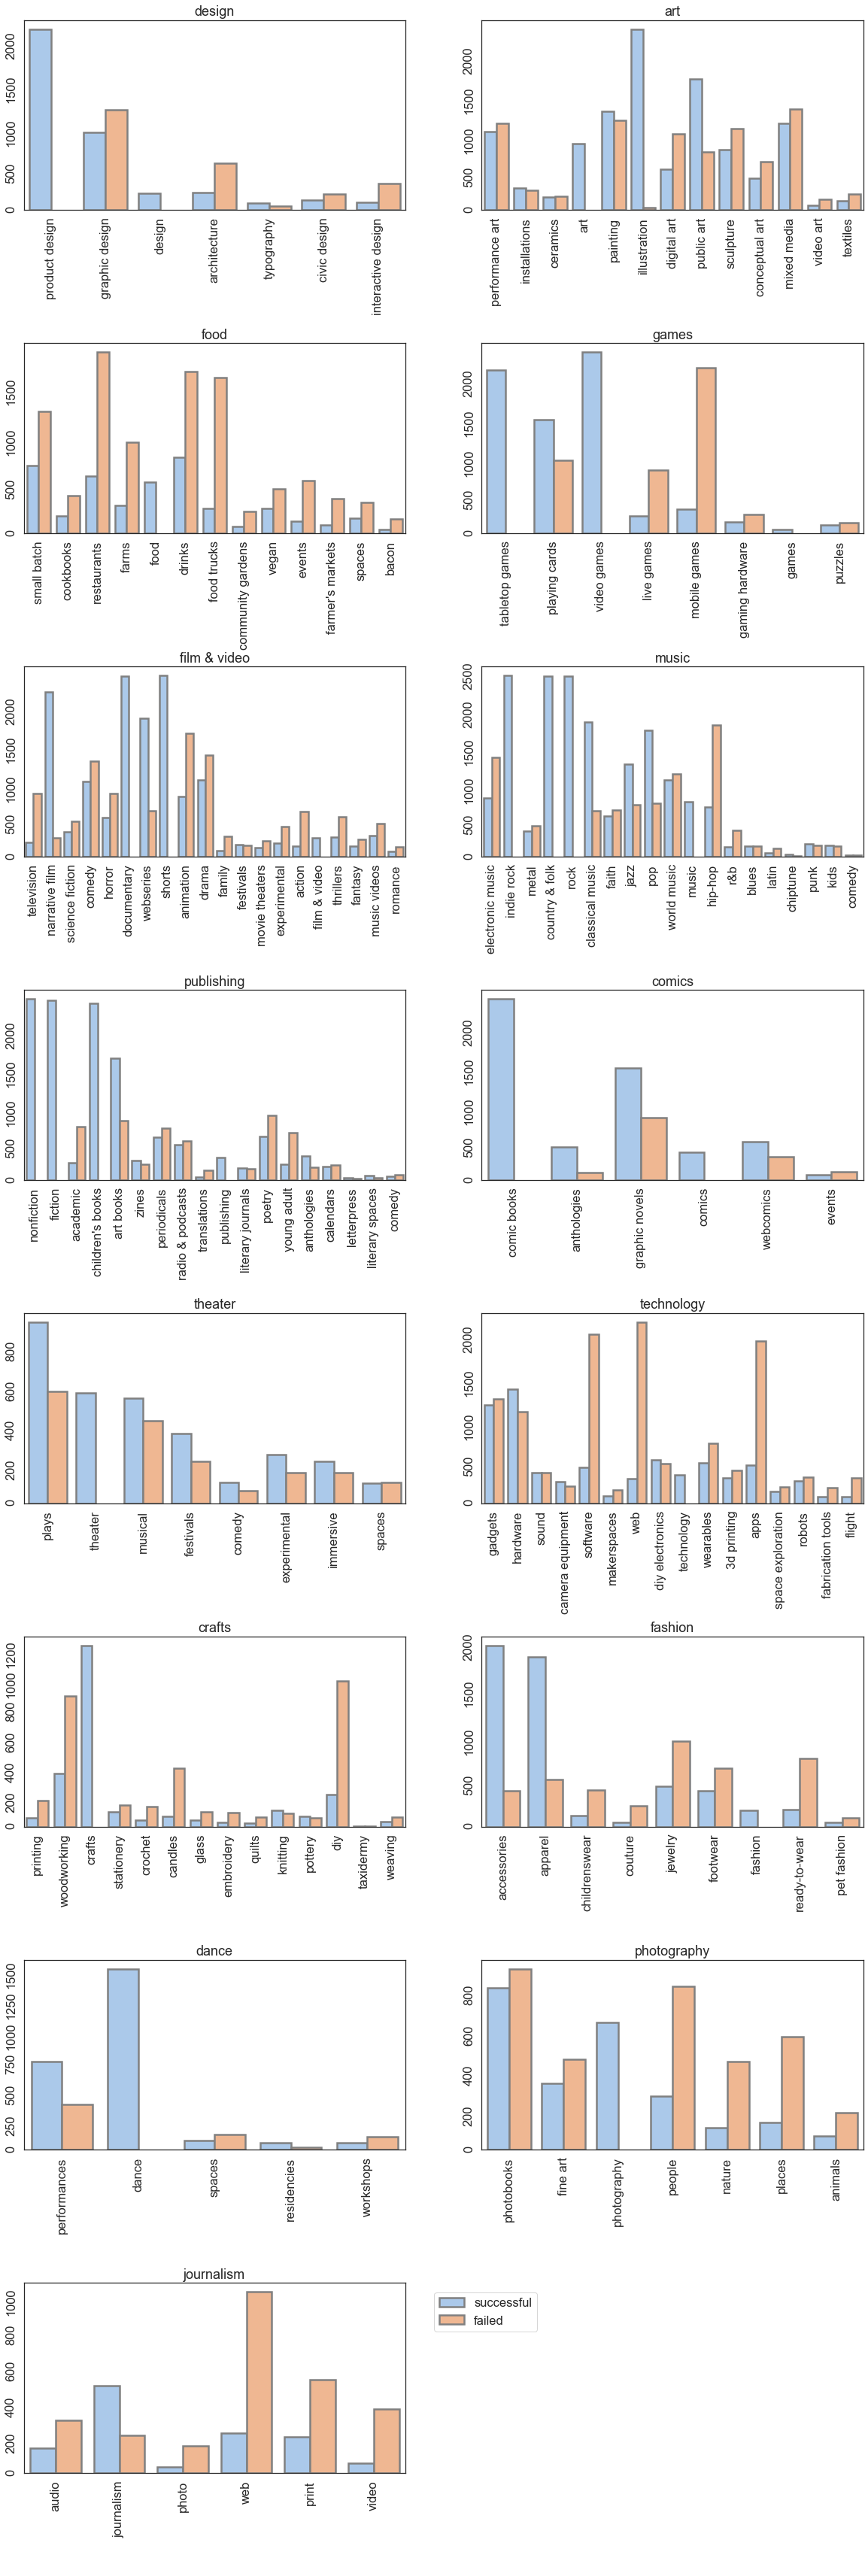

In [48]:
fig, ax = plt.subplots(ncols=2, nrows=8,figsize=(20,60),gridspec_kw={'hspace': 0.7})

for idx, elm in enumerate(df.main_cat.unique()):
    #plt.figure(idx, figsize=(6,4))
    sns.countplot(data=df[df["main_cat"] == elm],x="sub_cat", hue=df.state,ax=ax[int(idx/2)][idx%2],edgecolor="grey",linewidth=2.5)
    ax[int(idx/2)][idx%2].tick_params(rotation=90)
    ax[int(idx/2)][idx%2].set_title(elm)
    ax[int(idx/2)][idx%2].set_ylabel("")
    ax[int(idx/2)][idx%2].set_xlabel("")
    ax[int(idx/2)][idx%2].legend().set_visible(False)
handles, labels = ax[1][0].get_legend_handles_labels()
ax[7][1].set_visible(False)
fig.legend(handles, labels,loc=(0.5,0.095));

#for loop to print eacht category with its subcategory, to see if some categories have specific failure points
#(looking at you apps, software and web in technology!)

## goal

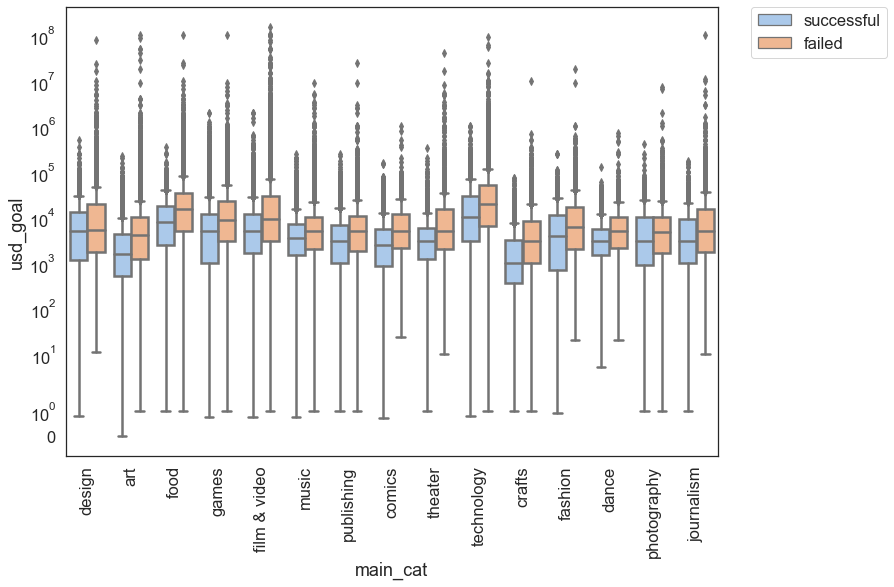

In [49]:
sns.boxplot(data=df, x="main_cat", y="usd_goal", hue="state")
plt.xticks(rotation=90)
plt.yscale("symlog")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fancybox=True);

# comparison by main cat if goal has an influence (higher = worse)

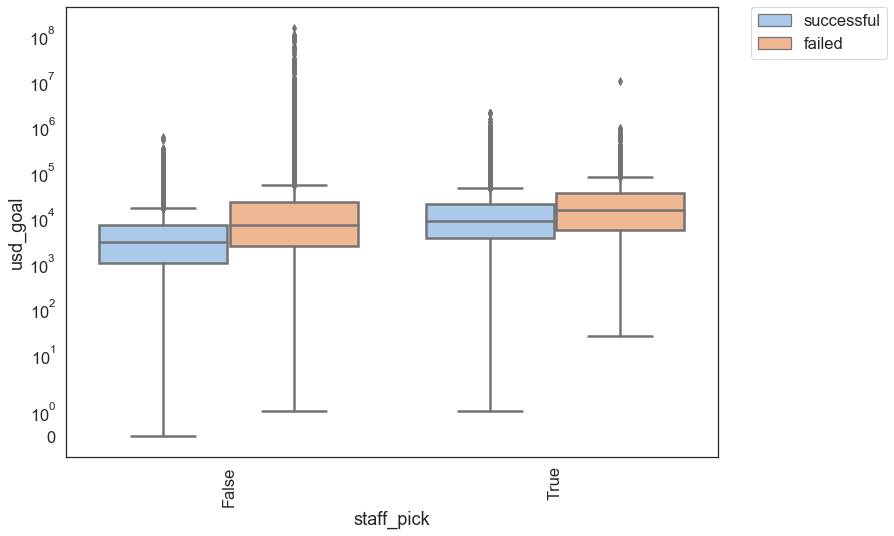

In [50]:
sns.boxplot(data=df, y="usd_goal",x="staff_pick",hue="state")
plt.xticks(rotation=90)
plt.yscale("symlog")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fancybox=True);

## bolean features

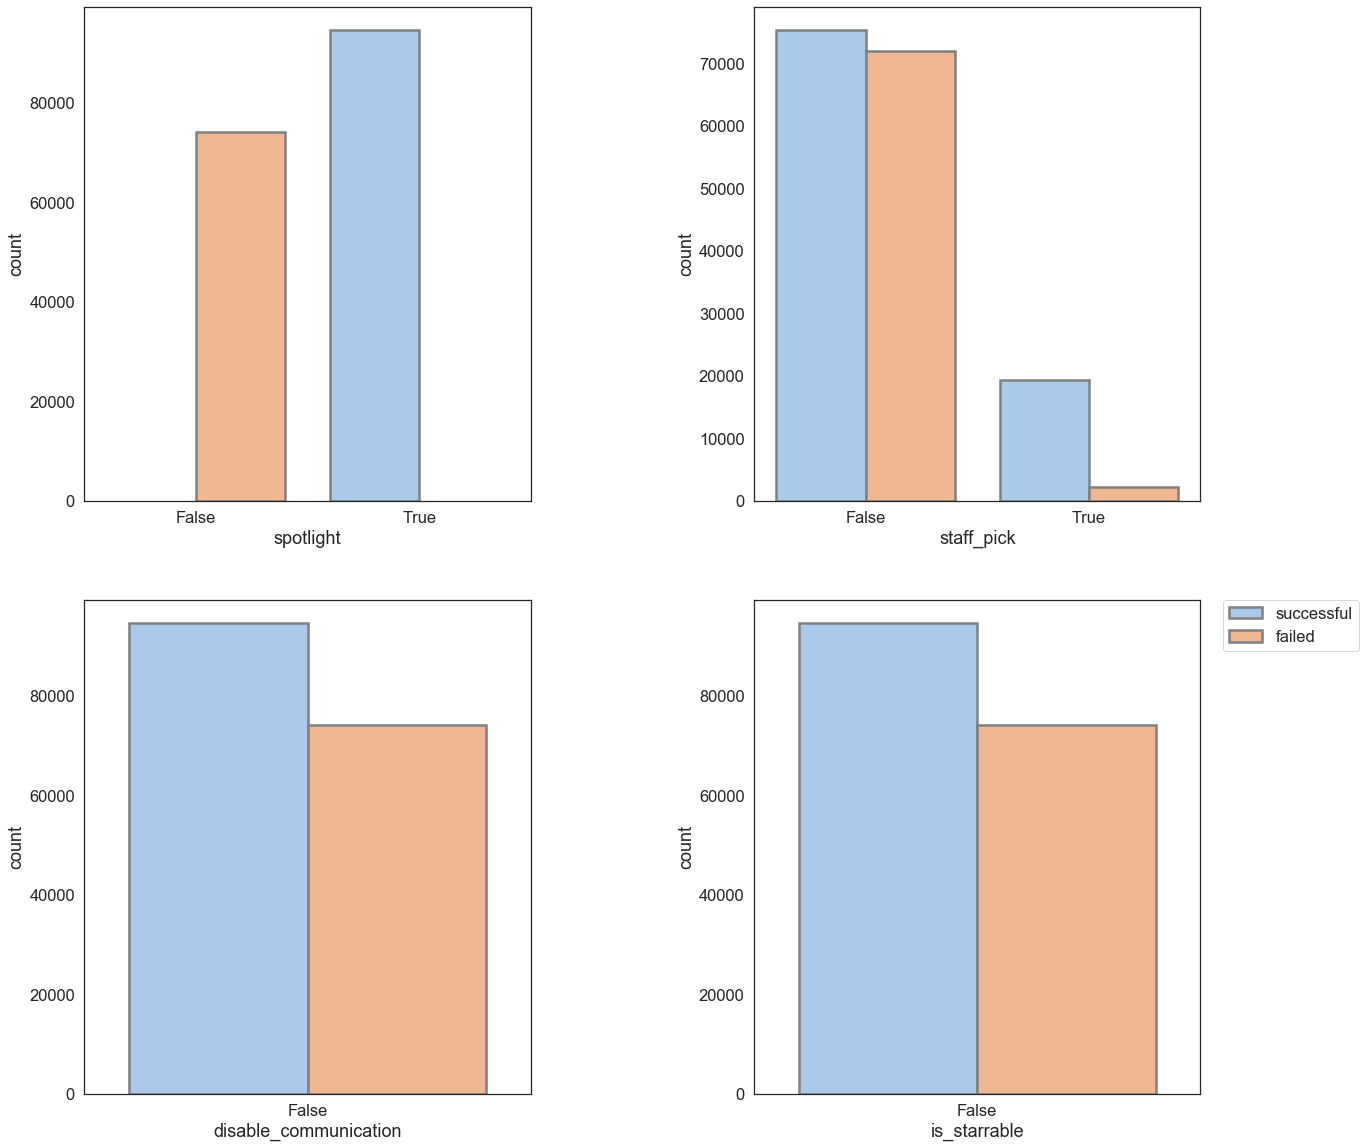

In [51]:
fig, ax = plt.subplots(ncols=2, nrows=2,figsize=(20,20),gridspec_kw={'wspace': 0.5})
sns.countplot(df.spotlight, hue=df.state,edgecolor="grey",ax=ax[0][0],linewidth=2.5)
sns.countplot(df.staff_pick, hue=df.state,edgecolor="grey",ax=ax[0][1],linewidth=2.5)
sns.countplot(df.disable_communication, hue=df.state,edgecolor="grey",ax=ax[1][0],linewidth=2.5)
sns.countplot(df.is_starrable, hue=df.state,edgecolor="grey",ax=ax[1][1],linewidth=2.5)
ax[0][0].legend().set_visible(False)
ax[0][1].legend().set_visible(False)
ax[1][0].legend().set_visible(False)
ax[1][1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fancybox=True);

# how are booleans related to this? spotlight, comm and starrable are not useful, as only one thing is there 
# staff pick also not useful, as you cannot know that beforehand

## name length

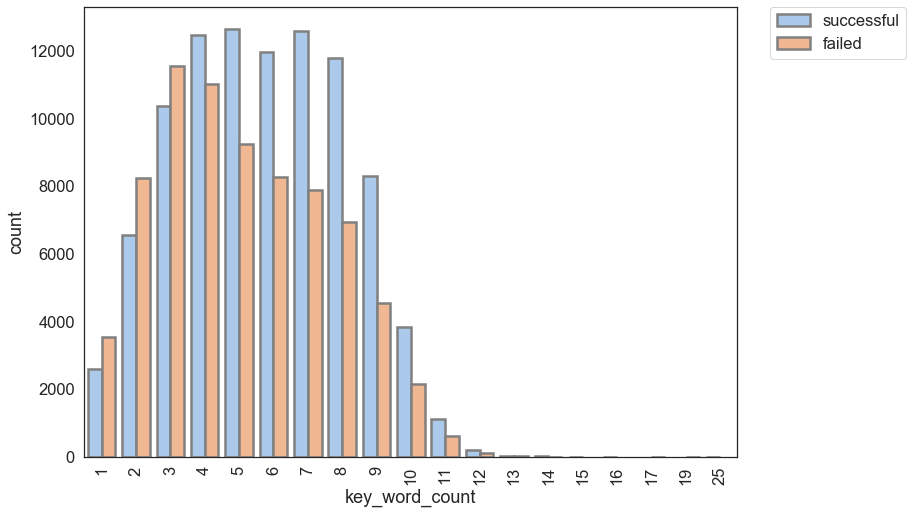

In [52]:
sns.countplot(df.key_word_count, hue=df.state,edgecolor="grey",linewidth=2.5)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fancybox=True);

# influence of name length, longer names seem to be better (more descriptive?)

## year and date

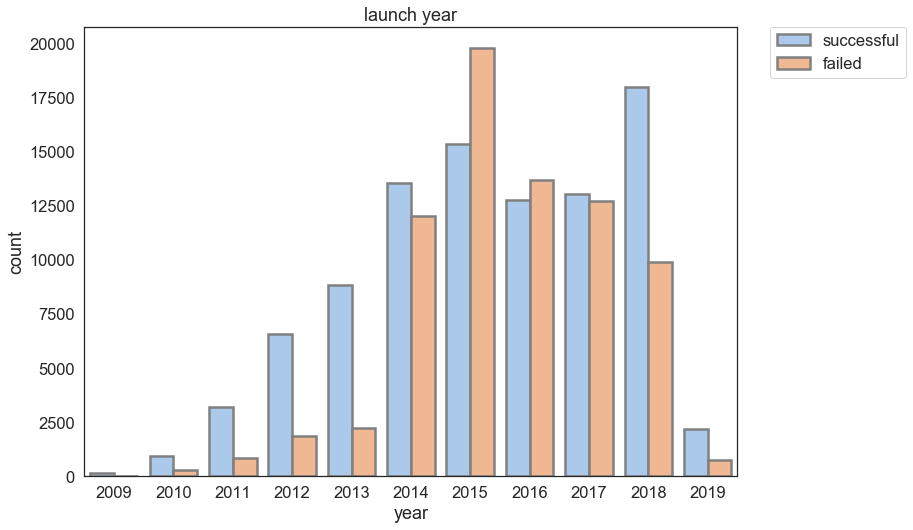

In [54]:
sns.countplot(data=df, x = 'year', hue = 'state',edgecolor="grey",linewidth=2.5)
plt.title("launch year")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fancybox=True);

# how does the year relate to succes? mabye hype at first, than small downer, now its going up again

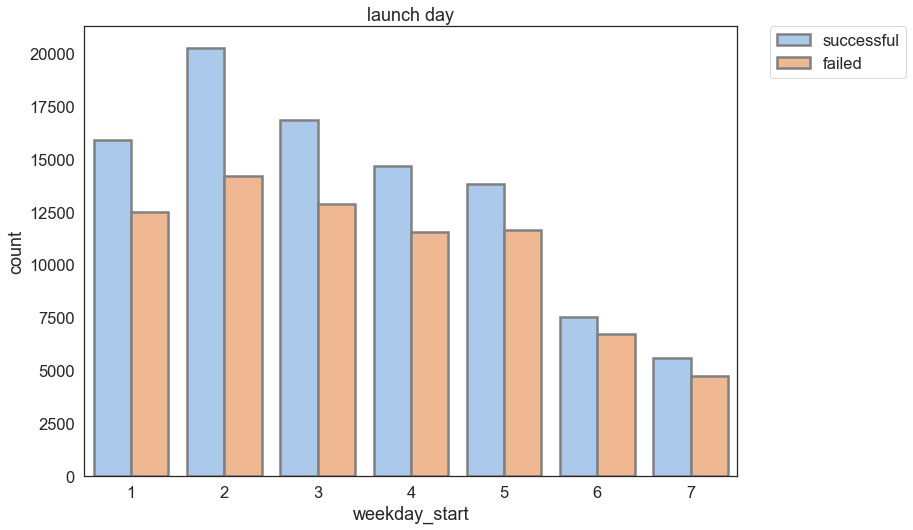

In [55]:
sns.countplot(data=df, x = 'weekday_start', hue = 'state',edgecolor="grey",linewidth=2.5)
plt.title("launch day")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fancybox=True);

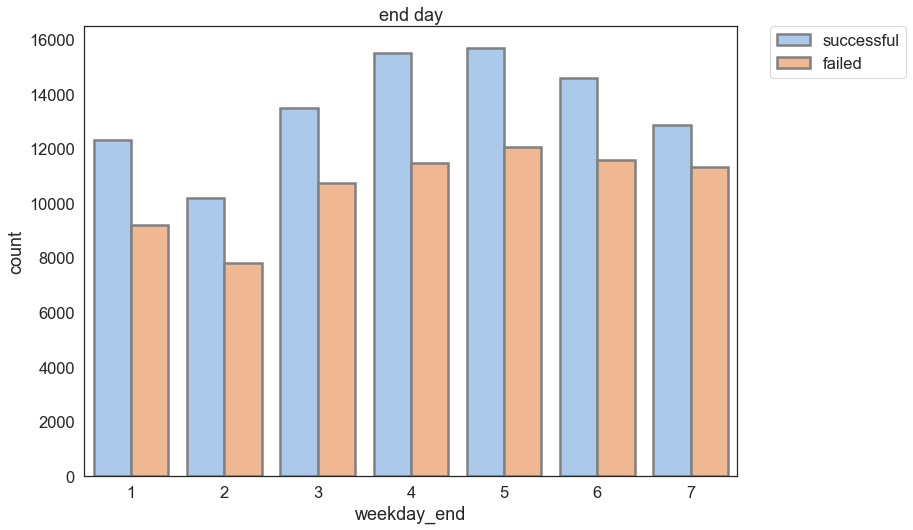

In [56]:
sns.countplot(data=df, x = 'weekday_end', hue = 'state',edgecolor="grey",linewidth=2.5)
plt.title("end day")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fancybox=True);

## maps

In [57]:
df_map = df["state"].groupby(df["country"]).value_counts(normalize=True).rename("prob").reset_index()

In [58]:
df_map["size"]=10

In [60]:
lat={"US":39.9,"GB":53.44,"FR":47.07,"AU":-25,"NZ":-41.93,'ES':40.06, 'IT':43.03, 'NO':61.52, 'NL':52.2, 'CA':60.26, 'SG':1.37,
       'MX':24.25, 'SE':62.89, 'IE':53.36, 'DE':51.08, 'BE':50.68, 'HK':22.39, 'AT':47.69, 'JP':36.59, 'DK':55.95, 'CH':46.89, 'LU':49.64}
long={"US": -102.1,"GB":-1.64,"FR":2.4,"AU":134.12,"NZ":172.88,'ES':-3.5, 'IT':12.6, 'NO':9.49, 'NL':5.65, 'CA':-110.66, 'SG':103.81,
       'MX':-102.45, 'SE':16.88, 'IE':-7.62, 'DE':10.34, 'BE':4.77, 'HK':114.16, 'AT':14.85, 'JP':139.16, 'DK':9.4, 'CH':8.21, 'LU':6.14}

In [61]:
df_map["lat"]=[lat[elm] for elm in df_map.country.values]
df_map["long"]=[long[elm] for elm in df_map.country.values]

In [62]:
fig = px.scatter_mapbox(df_map[df_map["state"]=="successful"], lat="lat", lon="long", 
                        hover_name="country",
                        text=df_map[df_map["state"]=="successful"].country,
                        #hover_data=[""],
                        zoom=1, 
                        #center={"lat":51.1, "lon":10.3},
                        color_continuous_scale=px.colors.sequential.Jet,
                        height=500, color="prob",
                        mapbox_style="open-street-map",opacity=1,
                        size="size", size_max=10)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# making a map with color correspodning to success rate

## final drop

In [63]:
df_model=df.drop(["backers_count","converted_pledged_amount","disable_communication",
                 "is_starrable","average_pledge","staff_pick","spotlight","year",
                 'state_changed_at','created_at','launched_at','deadline','main_cat',
                 'sub_cat','goal', 'static_usd_rate', 'fx_rate', 'slug', 'category','lat','long',"blurb",
                 "currency","currency_symbol", "currency_trailing_code", "current_currency",
                  "location","name","photo","source_url","urls","usd_type","profile","pledged","usd_pledged","blurb_len"], axis=1)

In [64]:
df_model.info()

# creating a dataframe for modeling with the relevant columns for modeling
# only those we can know and influence beforehand

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168764 entries, 0 to 168763
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   country         168764 non-null  object 
 1   creator         168764 non-null  object 
 2   state           168764 non-null  object 
 3   usd_goal        168764 non-null  float64
 4   cat             168764 non-null  object 
 5   key_word_count  168764 non-null  int64  
 6   month           168764 non-null  object 
 7   weekday_start   168764 non-null  object 
 8   weekday_end     168764 non-null  object 
 9   duration        168764 non-null  int16  
dtypes: float64(1), int16(1), int64(1), object(7)
memory usage: 11.9+ MB


## outlier removal

In [66]:
df_model.shape

(168764, 10)

In [67]:
feat=list(df_model.select_dtypes(include=[np.number]).columns.values)

In [68]:
df1 = df_model[feat]

In [69]:
df2 = df_model.drop(feat, axis=1)

In [70]:
from scipy import stats
z = np.abs(stats.zscore(df1))

In [71]:
df1 = df1[(z < 3).all(axis=1)]

In [72]:
df_model = pd.concat([df1,df2],axis=1).dropna()

In [73]:
df_model.shape

# remove outliers based on z score >= 3

(168147, 10)

## correlation matrix

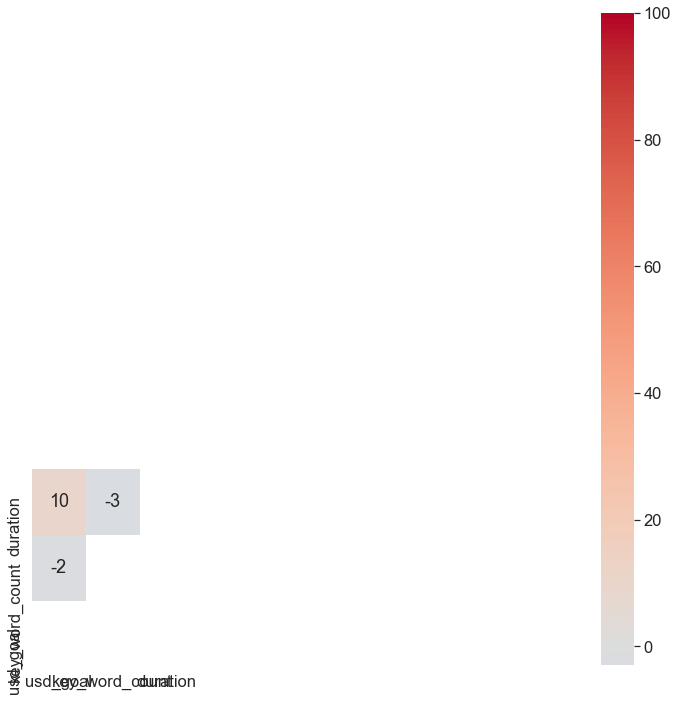

In [74]:
plt.figure (figsize=(12,12))
mask = np.triu(df_model.corr())
ax = sns.heatmap(round(df_model.corr()*100)
                 ,annot=True
                 ,mask=mask
                 ,cmap='coolwarm'
                 ,center=0)
ax.set_ylim((0,10))
ax.set_xlim((0,10));

# correlation matrix not very useful, since almost no cols are numeric

## pair plots

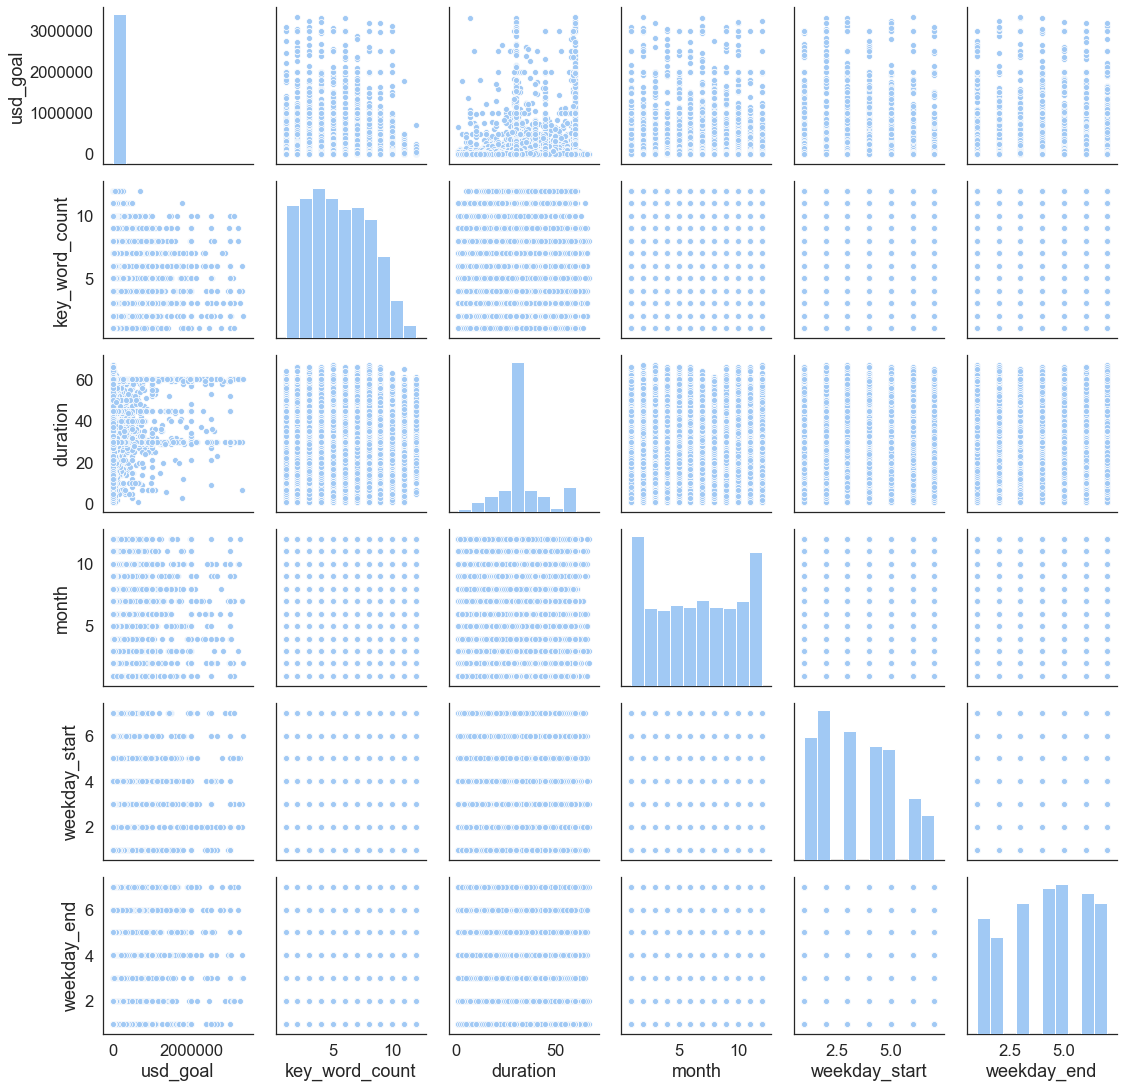

In [75]:
sns.pairplot(df_model);

#same with pairplots

# predictive modeling

In [76]:
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.metrics import make_scorer, confusion_matrix, fbeta_score, classification_report 
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from pactools.grid_search import GridSearchCVProgressBar

In [77]:
y = df_model.pop("state")

In [78]:
label_enc = LabelEncoder()
label_enc.fit(y)

LabelEncoder()

In [79]:
y=label_enc.transform(y)

In [80]:
X = df_model

In [81]:
X_finaltest, X_val, y_finaltest, y_val = train_test_split(X,y,random_state=10)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X_finaltest,y_finaltest,random_state=10)

# split into y and x and into train test val sets, encode successful and failed into 1 and 0

## profile ids after train test split

In [83]:
# count occurences of creator ids, only based on train set (as its the only one we know), store in dictionary and assign
# train test and val sets those numbers

ids = [int(re.findall(r'\d+', i)[0]) for i in X_train.creator]

In [84]:
id_counts = {elm:ids.count(elm) for elm in ids}

In [85]:
datasets=[X_finaltest, X_val,X_train, X_test]
for dataset in datasets:
    id_counts_train = [id_counts[int(re.findall(r'\d+', i)[0])] if int(re.findall(r'\d+', i)[0]) in id_counts 
                       else 1 for i in dataset.creator]
    dataset["profile_id_counts"] = id_counts_train.copy()
    dataset.drop("creator", inplace=True, axis=1)

C:\Users\neomo\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\neomo\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [86]:
X_test.head()

usd_goal  key_word_count  duration country  \
27589     378.54             4.0      21.0      AU   
25138     600.00             7.0      60.0      US   
142011   3398.01             8.0      20.0      MX   
2458     1538.85             9.0      36.0      GB   
107503  30000.00             4.0      30.0      US   

                                cat month weekday_start weekday_end  \
27589         comics/graphic novels     1             6           6   
25138   publishing/children's books     3             5           2   
142011             food/food trucks     9             2           1   
2458                     technology     3             7           1   
107503                  music/faith     6             1           3   

        profile_id_counts  
27589                   1  
25138                   1  
142011                  1  
2458                    1  
107503                  1

In [87]:
X_train.head()

usd_goal  key_word_count  duration country  \
111119  22928.36             8.0      33.0      CA   
7786    20000.00            11.0      30.0      US   
17409    8000.00             3.0      29.0      US   
27544    3500.00            10.0      21.0      US   
591      1200.00            10.0      26.0      US   

                                cat month weekday_start weekday_end  \
111119                  food/drinks    11             3           1   
7786     technology/diy electronics    11             2           4   
17409   film & video/narrative film    10             2           4   
27544            publishing/fiction     8             6           7   
591          film & video/webseries     1             6           4   

        profile_id_counts  
111119                  1  
7786                    3  
17409                   1  
27544                   2  
591                     1

## mode selection

In [88]:
numeric_features = list(X_train.select_dtypes(include=[np.number]).columns.values)

In [89]:
numeric_features

['usd_goal', 'key_word_count', 'duration', 'profile_id_counts']

In [90]:
object_features = list(X_train.select_dtypes(include=[np.object]).columns.values)

In [91]:
object_features

['country', 'cat', 'month', 'weekday_start', 'weekday_end']

In [92]:
imputer1 = SimpleImputer(strategy="median")
scaler1 = StandardScaler()
numeric_transformer = make_pipeline(imputer1,scaler1)


imputer2 = SimpleImputer(strategy='constant', fill_value='missing')
encoder = OneHotEncoder(handle_unknown='error',drop="first")
object_transformer = make_pipeline(imputer2,encoder)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', object_transformer, object_features)
    ])

# preprocessor for numeric and object features, sacler for numeric and onehot for object features

In [93]:
scorer = make_scorer(fbeta_score,beta=0.5) 
#scorer for gridsearch

### baseline model

In [ ]:
#baseline model with all 1 (success) for comp, then 6 different models with standard parameters to see which are viable 

In [ ]:
y_baseline = np.ones(len(y_test))

In [ ]:
confusion_matrix(y_test,y_baseline)

In [ ]:
print(classification_report(y_test,y_baseline))

In [ ]:
fbeta_score(y_test,y_baseline,0.5)

### logistic regression

In [ ]:
logit_clf = LogisticRegression(max_iter=1000)
model_logit = make_pipeline(preprocessor,logit_clf)

In [ ]:
model_logit.fit(X_train, y_train)

In [ ]:
y_pred = model_logit.predict(X_test)

In [ ]:
confusion_matrix(y_test,y_pred)

In [ ]:
print(classification_report(y_test,y_pred))

In [ ]:
fbeta_score(y_test,y_pred,0.5)

### knn

In [ ]:
knn_clf = KNeighborsClassifier()
model_knn = make_pipeline(preprocessor,knn_clf)

In [ ]:
model_knn.fit(X_train, y_train)

In [ ]:
y_pred = model_knn.predict(X_test)

In [ ]:
confusion_matrix(y_test,y_pred)

In [ ]:
print(classification_report(y_test,y_pred))

In [ ]:
fbeta_score(y_test,y_pred,0.5)

### SVC

In [ ]:
#svc_clf = SVC()
#model_svc = make_pipeline(preprocessor,svc_clf)

In [ ]:
#model_svc.fit(X_train, y_train)

In [ ]:
#y_pred = model_svc.predict(X_test)

In [ ]:
#confusion_matrix(y_test,y_pred)

In [ ]:
#print(classification_report(y_test,y_pred))

In [ ]:
#fbeta_score(y_test,y_pred,0.5)

### random forest

In [ ]:
rf_clf = RandomForestClassifier(random_state=10, n_jobs=-1)
model_rf_clf = make_pipeline(preprocessor,rfclf)

In [ ]:
model_rf_clf.fit(X_train, y_train)

In [ ]:
model_rf_clf.classes_

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
confusion_matrix(y_test,y_pred)

In [ ]:
print(classification_report(y_test,y_pred))

In [ ]:
fbeta_score(y_test,y_pred,0.5)

### adaboost

In [96]:
ada_clf = AdaBoostClassifier()
model_ada = make_pipeline(preprocessor,ada_clf)

In [97]:
model_ada.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                  

In [98]:
y_pred = model_ada.predict(X_test)

In [99]:
confusion_matrix(y_test,y_pred)

array([[11813,  2149],
       [ 5815, 11751]], dtype=int64)

In [100]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.67      0.85      0.75     13962
           1       0.85      0.67      0.75     17566

    accuracy                           0.75     31528
   macro avg       0.76      0.76      0.75     31528
weighted avg       0.77      0.75      0.75     31528



In [101]:
fbeta_score(y_test,y_pred,0.5)

0.8030369297214554

### xgboost

In [102]:
xgb_clf = XGBClassifier(n_jobs=-1,random_state=10)
model_xgb = make_pipeline(preprocessor,xgb_clf)

In [103]:
model_xgb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                  

In [106]:
y_pred = model_xgb.predict(X_test)

In [107]:
confusion_matrix(y_test,y_pred)

array([[ 9045,  4917],
       [ 3723, 13843]], dtype=int64)

In [108]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.71      0.65      0.68     13962
           1       0.74      0.79      0.76     17566

    accuracy                           0.73     31528
   macro avg       0.72      0.72      0.72     31528
weighted avg       0.72      0.73      0.72     31528



In [109]:
fbeta_score(y_test,y_pred,0.5)

0.7474137744854545

## hyperparameter tuning

In [ ]:
# iterative gridearch for hyperparameter tuning, chosen ones represent the best found

### random forest

In [ ]:
param_grid_rf= {'randomforestclassifier__n_estimators':[80,100,120],
                'randomforestclassifier__max_depth':[100,None],
               'randomforestclassifier__min_samples_split':[20,30],
               'randomforestclassifier__max_features':["sqrt",None]}

In [ ]:
grid = GridSearchCVProgressBar(model_rf_clf, param_grid_rf, scorer, verbose=1,return_train_score=False,n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)

In [ ]:
model_rf_clf.get_params().keys()

In [ ]:
y_pred=grid.predict(X_test)

In [ ]:
confusion_matrix(y_test,y_pred)

In [ ]:
print(classification_report(y_test,y_pred))

In [ ]:
fbeta_score(y_test,y_pred,0.5)

### adaboost

In [126]:
param_grid_ada= {'adaboostclassifier__n_estimators':[400],
                'adaboostclassifier__learning_rate':[0.45],
               'adaboostclassifier__random_state':[42]}

In [127]:
grid_ada = GridSearchCVProgressBar(model_ada, param_grid_ada, scorer,return_train_score=False,n_jobs=-1)
grid_ada.fit(X_train, y_train)
print(grid_ada.best_params_)

{'adaboostclassifier__learning_rate': 0.45, 'adaboostclassifier__n_estimators': 400, 'adaboostclassifier__random_state': 42}


lr:0.35, n_estimators:400

In [128]:
y_pred=grid_ada.predict(X_test)

In [129]:
confusion_matrix(y_test,y_pred)

array([[11148,  2814],
       [ 4421, 13145]], dtype=int64)

In [130]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.72      0.80      0.76     13962
           1       0.82      0.75      0.78     17566

    accuracy                           0.77     31528
   macro avg       0.77      0.77      0.77     31528
weighted avg       0.78      0.77      0.77     31528



In [131]:
fbeta_score(y_test,y_pred,0.5)

0.8074125942851527

In [132]:
best_ada = grid_ada.best_estimator_ 

### xgboost

In [141]:
param_grid_xgb = {'xgbclassifier__max_depth':[4],
                 'xgbclassifier__learning_rate':[0.1,0.15,0.2],
                 'xgbclassifier__n_estimators':[350,500],
                 'xgbclassifier__booster':["gbtree"],
                 'xgbclassifier__gamma':[5,8,12]}

In [142]:
grid_xgb = GridSearchCVProgressBar(model_xgb, param_grid_xgb, scorer, return_train_score=False,n_jobs=-1)
grid_xgb.fit(X_train, y_train)
print(grid_xgb.best_params_)

{'xgbclassifier__booster': 'gbtree', 'xgbclassifier__gamma': 5, 'xgbclassifier__learning_rate': 0.15, 'xgbclassifier__max_depth': 4, 'xgbclassifier__n_estimators': 500}


{'xgbclassifier__booster': 'gbtree', 'xgbclassifier__gamma': 5, 'xgbclassifier__learning_rate': 0.15, 'xgbclassifier__max_depth': 4, 'xgbclassifier__n_estimators': 500}

In [143]:
y_pred=grid_xgb.predict(X_test)

In [144]:
confusion_matrix(y_test,y_pred)

array([[11285,  2677],
       [ 4416, 13150]], dtype=int64)

In [145]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.72      0.81      0.76     13962
           1       0.83      0.75      0.79     17566

    accuracy                           0.78     31528
   macro avg       0.77      0.78      0.77     31528
weighted avg       0.78      0.78      0.78     31528



In [146]:
fbeta_score(y_test,y_pred,0.5)

0.8129930509187131

In [147]:
best_xgb = grid_xgb.best_estimator_ 

### SVC (deprecated)

In [ ]:
#param_grid_svc= {"svc__C":[0.1,1,10],
#                "svc__kernel":["rbf","sigmoid","poly"],
#                "svc__gamma":["scale","auto",0.1,1,10],
#                "svc__shrinking":[True,False],
#                "svc__random_state":[1]}

In [ ]:
#rand_grid_svc = RandomizedSearchCV(model_svc, param_grid_svc, scoring=scorer,n_jobs=-1)

In [ ]:
#rand_grid_svc.fit(X_train, y_train)

In [ ]:
#print(rand_grid_svc.best_params_)

## Validation

In [ ]:
# validation tests with the best performers, adaboost and xgboost

### ada_boost

In [ ]:
best_ada.fit(X_finaltest, y_finaltest)

In [ ]:
y_pred_val = best_ada.predict(X_val)

In [129]:
confusion_matrix(y_val,y_pred_val)

array([[11148,  2814],
       [ 4421, 13145]], dtype=int64)

In [130]:
print(classification_report(y_val,y_pred_val))

              precision    recall  f1-score   support

           0       0.72      0.80      0.76     13962
           1       0.82      0.75      0.78     17566

    accuracy                           0.77     31528
   macro avg       0.77      0.77      0.77     31528
weighted avg       0.78      0.77      0.77     31528



In [131]:
fbeta_score(y_val,y_pred_val,0.5)

0.8074125942851527

### XGBoost

In [148]:
best_xgb.fit(X_finaltest, y_finaltest)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                  

In [149]:
y_pred_val = best_ada.predict(X_val)

In [150]:
confusion_matrix(y_val,y_pred_val)

array([[14694,  3792],
       [ 5766, 17785]], dtype=int64)

In [151]:
print(classification_report(y_val,y_pred_val))

              precision    recall  f1-score   support

           0       0.72      0.79      0.75     18486
           1       0.82      0.76      0.79     23551

    accuracy                           0.77     42037
   macro avg       0.77      0.78      0.77     42037
weighted avg       0.78      0.77      0.77     42037



In [152]:
fbeta_score(y_val,y_pred_val,0.5)

0.8094466543478458

# Visualizations

## Total Amount by Year

In [153]:
dfsuc_year = dfsuc.groupby('year').sum().reset_index()
dfsuc_year.converted_pledged_amount = dfsuc_year.converted_pledged_amount / 1000000
dfsuc_year = dfsuc_year[dfsuc_year.year != 2019]

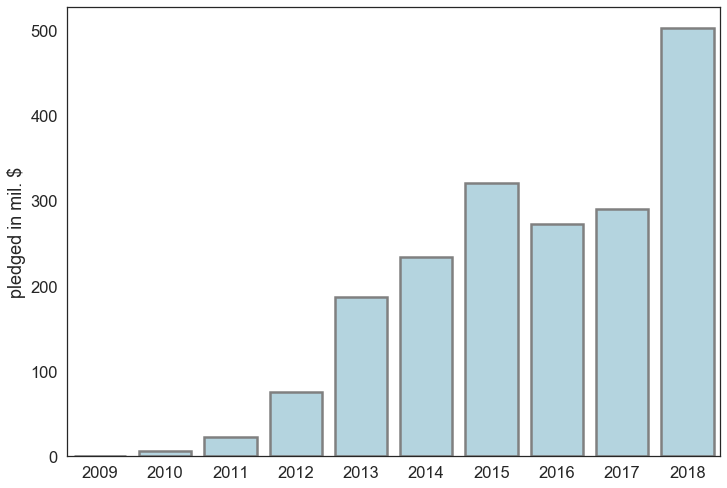

In [154]:
sns.barplot(x="year", y="converted_pledged_amount", data=dfsuc_year, color='lightblue',edgecolor="grey",linewidth=2.5);
plt.ylabel('pledged in mil. $')
plt.xlabel('');
plt.savefig('money', dpi=300)

# total amounts per year, sans2019 because data is not complete, kickstarter seems to be growing!

## maps

In [155]:
df_map = df["state"].groupby(df["country"]).value_counts(normalize=True).rename("Success rate").reset_index()

In [156]:
df_map2 = df["state"].groupby([df["country"],df["year"]]).value_counts(normalize=True).rename("Success rate").reset_index()

In [157]:
df_map2 = df_map2[df_map2["year"] !=2019].copy()

In [158]:
df_map["Success rate"] = round(df_map["Success rate"],2) 
df_map2["Success rate"] = round(df_map2["Success rate"],2) 

In [159]:
df_map["size"]=10
df_map2["size"]=10

In [160]:
lat={"US":39.9,"GB":53.44,"FR":47.07,"AU":-25,"NZ":-41.93,'ES':40.06, 'IT':43.03, 'NO':61.52, 'NL':52.2, 'CA':60.26, 'SG':1.37,
       'MX':24.25, 'SE':62.89, 'IE':53.36, 'DE':51.08, 'BE':50.68, 'HK':22.39, 'AT':47.69, 'JP':36.59, 'DK':55.95, 'CH':46.89, 'LU':49.64}
long={"US": -102.1,"GB":-1.64,"FR":2.4,"AU":134.12,"NZ":172.88,'ES':-3.5, 'IT':12.6, 'NO':9.49, 'NL':5.65, 'CA':-110.66, 'SG':103.81,
       'MX':-102.45, 'SE':16.88, 'IE':-7.62, 'DE':10.34, 'BE':4.77, 'HK':114.16, 'AT':14.85, 'JP':139.16, 'DK':9.4, 'CH':8.21, 'LU':6.14}

In [161]:
df_map["lat"]=[lat[elm] for elm in df_map.country.values]
df_map["long"]=[long[elm] for elm in df_map.country.values]

In [162]:
df_map2["lat"]=[lat[elm] for elm in df_map2.country.values]
df_map2["long"]=[long[elm] for elm in df_map2.country.values]

In [163]:
fig = px.scatter_mapbox(df_map[df_map["state"]=="successful"], lat="lat", lon="long", 
                        hover_name="country",
                        #text="state",
                        hover_data=["Success rate"],
                        zoom=0.75, 
                        #center={"lat":51.1, "lon":10.3},
                        color_continuous_scale=px.colors.sequential.Jet,
                        height=500, color="Success rate",
                        mapbox_style="open-street-map",opacity=1,
                        size="size", size_max=10,
                        title="Success rate by country")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(
    showlegend=False,
    annotations=[
        dict(
            x=0.13,
            y=0,
            text="Total",
            font=dict(
                color="black",
                size=75
            )
        )
    ]
)

fig.show()

#same as first map, with annotation

In [164]:
df_map2 = df_map2.sort_values("year").copy()

In [165]:
df_map2_suc = df_map2[df_map2["state"]=="successful"]

In [167]:
for year in np.arange(2009,2019):

    fig = px.scatter_mapbox(df_map2_suc[df_map2_suc["year"]==year], lat="lat", lon="long", 
                            hover_name="country",
                            #text="state",
                            hover_data=["Success rate"],
                            zoom=0.75, 
                            center={"lat":47.51, "lon":10.74},
                            color_continuous_scale=px.colors.sequential.Jet,
                            height=700, color="Success rate",
                            mapbox_style="open-street-map",opacity=1,
                            size="size", size_max=10,
                            title="Success rate by country",
                            #animation_frame="year",
                            range_color=[df_map2["Success rate"].min(),df_map2["Success rate"].max()])
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.update_layout(
    showlegend=False,
    annotations=[
        dict(
            x=0.13,
            y=0,
            text=str(year),
            font=dict(
                color="black",
                size=75
            )
        )
    ]
    )
    fig.show()
    fig.write_image("map"+str(year)+".png", width=1000, height=700, scale =3)
    
    #loop for making a map for each year with annotation

C:\Users\neomo\anaconda3\lib\site-packages\plotly\io\_orca.py:1532: ResourceWarning:

unclosed file <_io.BufferedWriter name='nul'>



## profile id counts

In [200]:
id_counts_train = [id_counts[int(re.findall(r'\d+', i)[0])] if int(re.findall(r'\d+', i)[0]) in id_counts 
                 else 1 for i in df.creator]
df_1 = df.copy()
df_1["profile_id_counts"] = id_counts_train.copy()

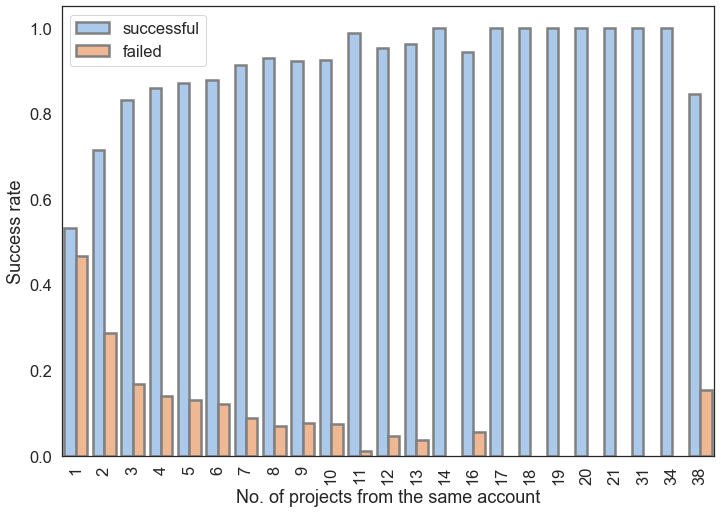

In [202]:
hue_order = ["successful","failed"]
sns.barplot(x="profile_id_counts", y="prob",
            data = df_1["state"].groupby(df_1["profile_id_counts"]).value_counts(normalize=True).rename("prob").reset_index(),
            hue="state",edgecolor="grey",linewidth=2.5,hue_order=hue_order)
plt.xticks(rotation=90)
plt.ylabel("Success rate")
plt.xlabel("No. of projects from the same account")
plt.legend(title=None);
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fancybox=True);
plt.savefig("profile_id_counts.png", dpi=300,bbox_inches='tight')

#plot succ rates for profile id counts, experience pays off!

# Example Case

## lord of chains

In [183]:
ex_case = { 'usd_goal':[50000,50000], 'key_word_count':[3,3],
           "duration":[35,35],'country':['DE', 'US'],'cat':["comics/graphic novels","comics/comic books"],
            "month":[12,10],'weekday_start':[7,2],
           'weekday_end':[7,2],'profile_id_counts':[1,20] } 
df_excase = pd.DataFrame(ex_case)

# construct two different versions for example case, one likely to fail one likely to succeed

In [184]:
df_excase["month"] = df_excase.month.astype("object")
df_excase["weekday_start"] = df_excase.weekday_start.astype("object")
df_excase["weekday_end"] = df_excase.weekday_end.astype("object")

In [203]:
excase_pred = best_xgb.predict(df_excase)
excase_pred

# predict for ex case with best classifier, 0 for first 1 for second

array([0, 1])

# future work

* Total pledge amount prediction for successful proposals, to maximize our profit
* In depth analysis of projects’ short description (blurb) to optimize chances of success
* Prediction of whether or not a project will be chosen as a staff pick
